# **📄 Document type classification**


# 0. 라이브러리 임포트

In [1]:
%pip install timm -q
%pip install --upgrade albumentations -q

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import random

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

# 데이터 증강시 이미지 오버레이 할 때 사용
from albumentations.core.transforms_interface import ImageOnlyTransform

# 1. 시드 고정

In [2]:
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

# 2. 데이터셋 클래스, 에폭함수 정의

In [3]:
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

In [4]:
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)

        model.zero_grad(set_to_none=True)

        preds = model(image)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret

# 3. 하이퍼파라미터 정의

- 24080502
    - BATCH_SIZE: 64 -> 128

In [5]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model config
model_name = 'resnet50' # 'efficientnet_b2' # 'resnet34' , ...

# training config
img_size = 224 # 224로 하는 게 더 잘 나옴
LR = 1e-3
EPOCHS = 100
BATCH_SIZE = 128
num_workers = 8

device

device(type='cuda')

# 4. 데이터 불러오기

## 4.1 빛번짐효과 클래스 정의

In [6]:
class RandomLensFlare(ImageOnlyTransform):
    def __init__(self, flare_center=None, angle_lower=0.0, angle_upper=1.0,
                 num_flare_circles_lower=6, num_flare_circles_upper=10,
                 src_radius=200, src_color=(255, 255, 255), always_apply=False, p=0.5):
        super(RandomLensFlare, self).__init__(always_apply, p)
        self.flare_center = flare_center
        self.angle_lower = angle_lower
        self.angle_upper = angle_upper
        self.num_flare_circles_lower = num_flare_circles_lower
        self.num_flare_circles_upper = num_flare_circles_upper
        self.src_radius = src_radius
        self.src_color = src_color

    def apply(self, img, **params):
        h, w, _ = img.shape
        flare_center = (random.randint(0, w), random.randint(0, h)) if self.flare_center is None else self.flare_center
        angle = random.uniform(self.angle_lower, self.angle_upper)
        num_flare_circles = random.randint(self.num_flare_circles_lower, self.num_flare_circles_upper)
        
        overlay = img.copy()
        for _ in range(num_flare_circles):
            alpha = random.uniform(0.05, 0.2)
            radius = random.randint(5, self.src_radius)
            center = (int(flare_center[0] + random.uniform(-w/2, w/2)),
                      int(flare_center[1] + random.uniform(-h/2, h/2)))
            cv2.circle(overlay, center, radius, self.src_color, -1)
            img = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)

        return img

## 4.2 이미지 겹치는 클래스 정의

- 이거는 적용했더니 더 떨어짐

In [7]:
class RandomImageOverlay(A.ImageOnlyTransform):
    def __init__(self, overlay_dir, alpha=0.5, always_apply=False, p=0.5):
        super(RandomImageOverlay, self).__init__(always_apply, p)
        self.overlay_dir = overlay_dir
        self.alpha = alpha
        self.overlay_images = [os.path.join(overlay_dir, img) for img in os.listdir(overlay_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

    def apply(self, img, **params):
        overlay_path = random.choice(self.overlay_images)
        overlay = cv2.imread(overlay_path)
        overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
        
        # Resize overlay to match the size of the input image
        overlay = cv2.resize(overlay, (img.shape[1], img.shape[0]))

        # Blend the images
        blended_image = cv2.addWeighted(img, 1 - self.alpha, overlay, self.alpha, 0)
        return blended_image
    
# 오버레이 이미지 경로
overlay_dir = '/home/code/train'

---

## 4.3 데이터 증강- 한번에 모두

- 24080501
    - 전체적으로 좀 더 부드럽게 만듦

### 4.3.1 trn_transform, tst_transform 정의

In [8]:
# 학습 이미지 변환 설정
trn_transform = A.Compose([
    A.LongestMaxSize(max_size=img_size),  # 이미지의 가장 긴 변을 img_size에 맞춤
    A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=cv2.BORDER_CONSTANT, value=[255, 255, 255]),
    
    # 색 조정
    A.OneOf([
        # 명암대비 높이는 변환
        # A.Equalize(),
        # saturation: 채도 / Hue: 색조
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        # 색조, 채도, 밝기 이동 범위
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.4),
        # 색상 왜곡
        A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10)
    ], p=0.4),

    # 노이즈 처리
    A.OneOf([
        # 이미지에 랜덤한 픽셀값 추가해서 노이즈 줌
        A.GaussNoise(var_limit=(10.0, 20.0), mean=0),
        # 압축해서 이미지 품질을 저하시키는 변환
        A.ImageCompression(quality_lower=5, quality_upper=15, p=0.2),
    ], p=0.4),

    # 선명 or 흐릿
    A.OneOf([
        # 선명
        A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8)),
        A.Sharpen(alpha=(0.2, 0.4), lightness=(0.5, 1.0)),
        A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8)),
        A.Sharpen(alpha=(0.2, 0.4), lightness=(0.5, 1.0)),

        # 흐릿
        A.GaussianBlur(blur_limit=(3, 3), sigma_limit=(0, 0)),
        # 이미지의 세부사항을 부드럽게 만듦
        A.MedianBlur(blur_limit=(3, 3)),
        A.MotionBlur(blur_limit=(3, 3)),
        # 안개 효과/ alpha_coef: 안개의 투명도
        A.RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.2, alpha_coef=0.08),
        # 눈 효과/ brightness_coeff: 눈의 밝기
        A.RandomSnow(snow_point_lower=0.1, snow_point_upper=0.2, brightness_coeff=2),
        # 비 효과/ slant: 빗방울 기울기
        A.RandomRain(slant_lower=-3, slant_upper=3, drop_length=2, drop_width=1,
                     drop_color=(200, 200, 200), blur_value=5, brightness_coefficient=0.7)
    ], p=0.5),

    # Grid Dropout, 빛번짐
    A.OneOf([
        A.GridDropout(ratio=0.3, unit_size_min=None, unit_size_max=50, holes_number_x=6, holes_number_y=6, shift_x=0, shift_y=0, random_offset=False, fill_value=255, mask_fill_value=None, always_apply=False, p=1.0),
        RandomLensFlare(flare_center=None, angle_lower=0.0, angle_upper=1.0,
                    num_flare_circles_lower=6, num_flare_circles_upper=10,
                    src_radius=200, src_color=(255, 255, 255), p=1.0)
    ], p=0.3),

    # 랜덤 오버레이 적용
    # RandomImageOverlay(overlay_dir=overlay_dir, alpha=0.3,always_apply=False,p=0.7),
    
    A.Rotate(limit=(-179, 179), p=0.8),
    A.HorizontalFlip(p=0.6),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
    ])

/opt/conda/lib/python3.10/site-packages/pydantic/main.py:364: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


In [9]:
# test image 변환 설정
tst_transform = A.Compose([
    # A.Resize(height=img_size, width=img_size),
    A.LongestMaxSize(max_size=img_size),  # 이미지의 가장 긴 변을 img_size에 맞춤
    A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=cv2.BORDER_CONSTANT, value=[0, 0, 0]),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

### 4.3.2 어떻게 나오나 출력해서 확인

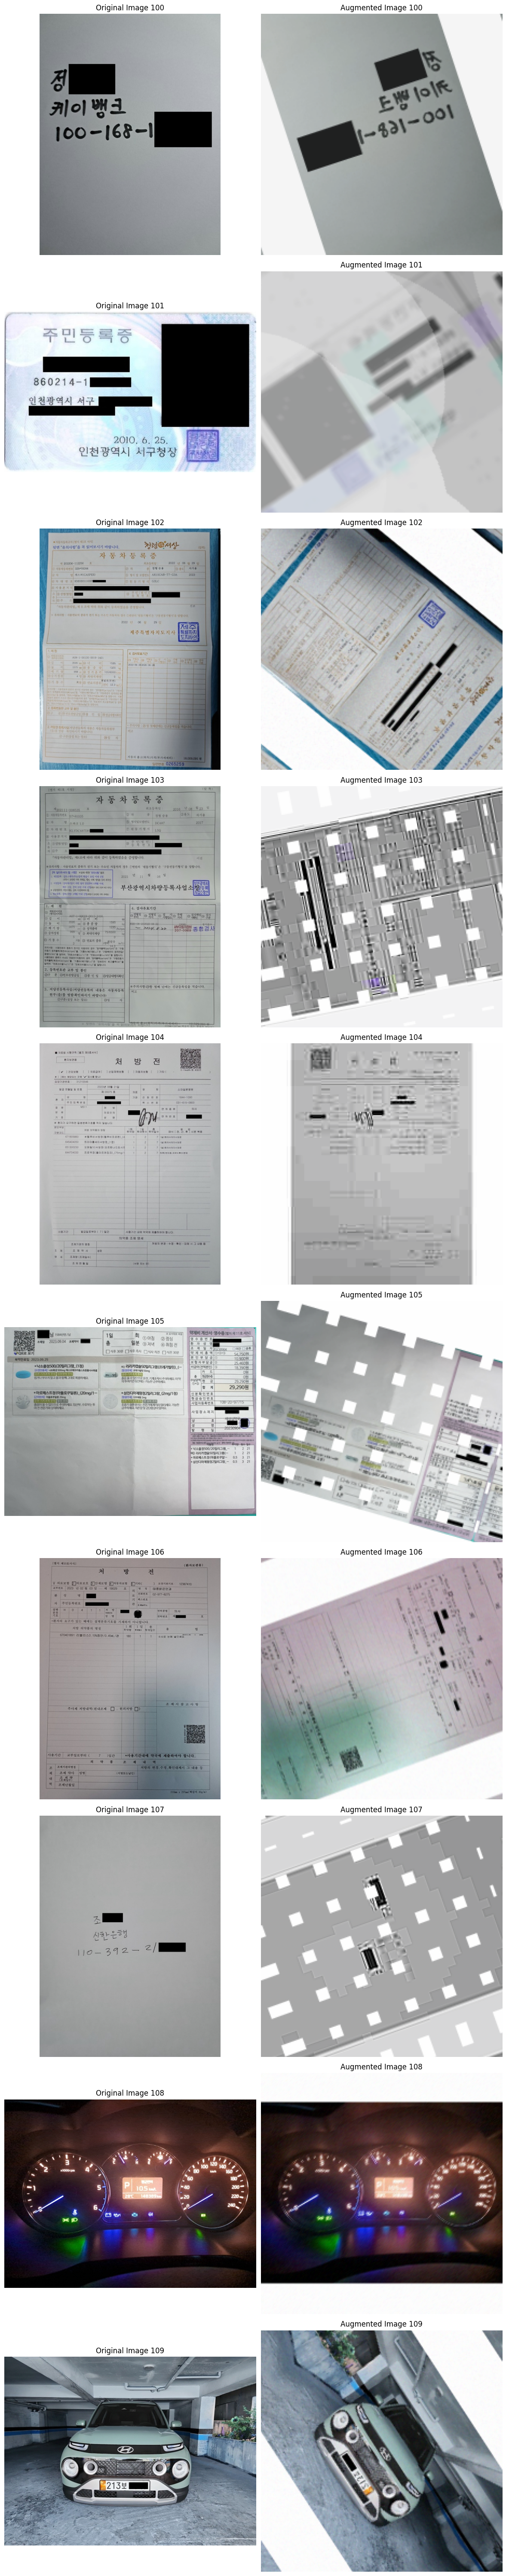

In [10]:
# 이미지 디렉토리와 인덱스 범위 설정
image_dir = '/home/code/train'
start_index = 100
end_index = 110

# 이미지 로드
image_paths = sorted(os.listdir(image_dir))[start_index:end_index]
images = [cv2.imread(os.path.join(image_dir, img_path)) for img_path in image_paths]
images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images]

# 변환 적용 및 시각화
fig, axs = plt.subplots(len(images), 2, figsize=(12, 6 * len(images)))

for i, image in enumerate(images):
    # 변환 적용
    augmented = trn_transform(image=image)
    transformed_image = augmented['image'].permute(1, 2, 0).cpu().numpy()  # 텐서를 다시 이미지로 변환
    transformed_image = (transformed_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))  # 정규화를 되돌림
    transformed_image = (transformed_image * 255).astype(np.uint8)  # 이미지를 다시 0-255 범위로 변환

    # 원본 이미지 시각화
    axs[i, 0].imshow(image)
    axs[i, 0].set_title(f'Original Image {i + start_index}')
    axs[i, 0].axis('off')

    # 변환된 이미지 시각화
    axs[i, 1].imshow(transformed_image)
    axs[i, 1].set_title(f'Augmented Image {i + start_index}')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

## 4.4 Dataset 정의

In [11]:
trn_dataset = ImageDataset(
    # "/home/code/train.csv",
    "/home/code/train.csv",
    "/home/code/train",
    transform=trn_transform
)
tst_dataset = ImageDataset(
    "/home/code/sample_submission.csv",
    "/home/code/test/",
    transform=tst_transform
)
print(len(trn_dataset), len(tst_dataset))

1570 3140


## 4.5 DataLoader 정의

In [12]:
trn_loader = DataLoader(
    trn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)
tst_loader = DataLoader(
    tst_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

# 5. 모델 학습

## 5.1 모델 불러오기

In [13]:
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
INFO:timm.models._hub:[timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


In [ ]:
print(timm.list_models())

['bat_resnext26ts', 'beit_base_patch16_224', 'beit_base_patch16_384', 'beit_large_patch16_224', 'beit_large_patch16_384', 'beit_large_patch16_512', 'beitv2_base_patch16_224', 'beitv2_large_patch16_224', 'botnet26t_256', 'botnet50ts_256', 'caformer_b36', 'caformer_m36', 'caformer_s18', 'caformer_s36', 'cait_m36_384', 'cait_m48_448', 'cait_s24_224', 'cait_s24_384', 'cait_s36_384', 'cait_xs24_384', 'cait_xxs24_224', 'cait_xxs24_384', 'cait_xxs36_224', 'cait_xxs36_384', 'coat_lite_medium', 'coat_lite_medium_384', 'coat_lite_mini', 'coat_lite_small', 'coat_lite_tiny', 'coat_mini', 'coat_small', 'coat_tiny', 'coatnet_0_224', 'coatnet_0_rw_224', 'coatnet_1_224', 'coatnet_1_rw_224', 'coatnet_2_224', 'coatnet_2_rw_224', 'coatnet_3_224', 'coatnet_3_rw_224', 'coatnet_4_224', 'coatnet_5_224', 'coatnet_bn_0_rw_224', 'coatnet_nano_cc_224', 'coatnet_nano_rw_224', 'coatnet_pico_rw_224', 'coatnet_rmlp_0_rw_224', 'coatnet_rmlp_1_rw2_224', 'coatnet_rmlp_1_rw_224', 'coatnet_rmlp_2_rw_224', 'coatnet_rmlp_2

In [102]:
for images, targets in trn_loader:
    print(images.shape)
    print(targets.shape)
    break

torch.Size([64, 3, 224, 224])
torch.Size([64])


- 여기서 계속 이런 오류가 나서 화났는데 tensor 배열을 잘못 맞춰서 생긴 문제였다. 도대체 어디더 ToTensorV2()를 빼먹었는지 도무지 알 수 없어서 한 4시간 헤매다가 내가 임의로 베이스라인 코드를 주석처리하고 순서를 바꿔놨다는 사실을 깨닫고 해결했다.. 정확한 이해 없이 어케든 만져보려고 하니 이런 삽질이 항상 생기네요.. 머 익숙해서 이제 해탈할 것 같음   

RuntimeError                              Traceback (most recent call last)
Cell In[45], line 2
      1 for epoch in range(EPOCHS):
----> 2     ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device=device)
      3     ret['epoch'] = epoch
      5     log = ""

Cell In[5], line 15
     11 targets = targets.to(device)
     13 model.zero_grad(set_to_none=True)
---> 15 preds = model(image)
     16 loss = loss_fn(preds, targets)
     17 loss.backward()

File /opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518, in Module._wrapped_call_impl(self, *args, **kwargs)
   1516     return self._compiled_call_impl(*args, **kwargs)  # type: ignore[misc]
   1517 else:
-> 1518     return self._call_impl(*args, **kwargs)

File /opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1527, in Module._call_impl(self, *args, **kwargs)
   1522 # If we don't have any hooks, we want to skip the rest of the logic in
   1523 # this function, and just call forward.
   1524 if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks or self._forward_pre_hooks
   1525         or _global_backward_pre_hooks or _global_backward_hooks
...
    455                     _pair(0), self.dilation, self.groups)
--> 456 return F.conv2d(input, weight, bias, self.stride,
    457                 self.padding, self.dilation, self.groups)

RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[64, 260, 260, 3] to have 3 channels, but got 260 channels instead
Output is truncated. View as a scrollable element or open in a text editor

## 5.2 모델 학습시키기

- Validation loss가 반비례곡선을 타야하는데 아닌 걸 보니 구하는 식에서 무엇인가가 잘못된 것 같습니다..   
    결과에는 영향을 주진 않는 것 같으므로 수정하지 않고 일단 놔뒀습니다.

In [14]:
# 새로운 폴더 생성
model_save_dir = '/home/code/24080502model'
os.makedirs(model_save_dir, exist_ok=True)

def validate(val_loader, model, loss_fn, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    accuracy = 100 * correct / total
    return val_loss / len(val_loader), accuracy

# 데이터 기록을 위한 리스트 초기화
val_losses = []
train_f1s = []

best_f1 = 0.0
best_model_path = '/home/code/24080502_best_model.pth'

for epoch in range(EPOCHS):
    # 학습 함수 호출 (train_one_epoch)
    ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device=device)
    ret['epoch'] = epoch

    # 검증 함수 호출
    val_loss, val_accuracy = validate(tst_loader, model, loss_fn, device)
    ret['val_loss'] = val_loss
    ret['val_accuracy'] = val_accuracy

    # 값 기록
    val_losses.append(val_loss)
    train_f1s.append(ret['train_f1'])

    log = ""
    for k, v in ret.items():
        log += f"{k}: {v:.4f}\n"
    print(log)

    # 모델 저장 로직
    model_save_path = os.path.join(model_save_dir, f'model_epoch_{epoch}.pth')
    torch.save(model.state_dict(), model_save_path)

    # 최상의 모델 저장 로직
    if ret['train_f1'] > best_f1:
        best_f1 = ret['train_f1']
        torch.save(model.state_dict(), best_model_path)
        print(f"새로운 최상의 모델이 저장되었습니다: train_f1 {best_f1:.4f}")

print(f"훈련 완료. 최상의 모델 F1 스코어: {best_f1:.4f}")

Loss: 2.2053: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]


train_loss: 2.5988
train_acc: 0.2554
train_f1: 0.2523
epoch: 0.0000
val_loss: 2.9636
val_accuracy: 6.1465

새로운 최상의 모델이 저장되었습니다: train_f1 0.2523


Loss: 1.3314: 100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


train_loss: 1.6367
train_acc: 0.5987
train_f1: 0.5101
epoch: 1.0000
val_loss: 5.7646
val_accuracy: 7.2293

새로운 최상의 모델이 저장되었습니다: train_f1 0.5101


Loss: 0.5563: 100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


train_loss: 0.8693
train_acc: 0.7070
train_f1: 0.6330
epoch: 2.0000
val_loss: 9.3522
val_accuracy: 6.2420

새로운 최상의 모델이 저장되었습니다: train_f1 0.6330


Loss: 0.8351: 100%|██████████| 13/13 [00:04<00:00,  3.08it/s]


train_loss: 0.6516
train_acc: 0.7720
train_f1: 0.7449
epoch: 3.0000
val_loss: 9.4656
val_accuracy: 6.4331

새로운 최상의 모델이 저장되었습니다: train_f1 0.7449


Loss: 0.3319: 100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


train_loss: 0.4726
train_acc: 0.8274
train_f1: 0.7963
epoch: 4.0000
val_loss: 8.4484
val_accuracy: 6.8790

새로운 최상의 모델이 저장되었습니다: train_f1 0.7963


Loss: 0.4145: 100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


train_loss: 0.3715
train_acc: 0.8675
train_f1: 0.8552
epoch: 5.0000
val_loss: 9.7085
val_accuracy: 6.5287

새로운 최상의 모델이 저장되었습니다: train_f1 0.8552


Loss: 0.5327: 100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


train_loss: 0.3331
train_acc: 0.8822
train_f1: 0.8703
epoch: 6.0000
val_loss: 9.1528
val_accuracy: 6.5605

새로운 최상의 모델이 저장되었습니다: train_f1 0.8703


Loss: 0.3266: 100%|██████████| 13/13 [00:04<00:00,  3.10it/s]


train_loss: 0.3063
train_acc: 0.8815
train_f1: 0.8638
epoch: 7.0000
val_loss: 9.8954
val_accuracy: 6.4013



Loss: 0.3354: 100%|██████████| 13/13 [00:04<00:00,  3.12it/s]


train_loss: 0.2858
train_acc: 0.9019
train_f1: 0.8869
epoch: 8.0000
val_loss: 10.7716
val_accuracy: 6.1465

새로운 최상의 모델이 저장되었습니다: train_f1 0.8869


Loss: 0.4864: 100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


train_loss: 0.2680
train_acc: 0.9070
train_f1: 0.8963
epoch: 9.0000
val_loss: 11.3023
val_accuracy: 6.2420

새로운 최상의 모델이 저장되었습니다: train_f1 0.8963


Loss: 0.4231: 100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


train_loss: 0.2488
train_acc: 0.9146
train_f1: 0.9047
epoch: 10.0000
val_loss: 9.2595
val_accuracy: 6.5924

새로운 최상의 모델이 저장되었습니다: train_f1 0.9047


Loss: 0.2963: 100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


train_loss: 0.2256
train_acc: 0.9096
train_f1: 0.9006
epoch: 11.0000
val_loss: 10.7295
val_accuracy: 6.4013



Loss: 0.1008: 100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


train_loss: 0.2029
train_acc: 0.9217
train_f1: 0.9132
epoch: 12.0000
val_loss: 11.0126
val_accuracy: 6.4968

새로운 최상의 모델이 저장되었습니다: train_f1 0.9132


Loss: 0.3445: 100%|██████████| 13/13 [00:04<00:00,  3.10it/s]


train_loss: 0.2086
train_acc: 0.9197
train_f1: 0.9131
epoch: 13.0000
val_loss: 11.8317
val_accuracy: 6.1783



Loss: 0.0770: 100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


train_loss: 0.1872
train_acc: 0.9299
train_f1: 0.9220
epoch: 14.0000
val_loss: 11.7848
val_accuracy: 6.4013

새로운 최상의 모델이 저장되었습니다: train_f1 0.9220


Loss: 0.1937: 100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


train_loss: 0.1917
train_acc: 0.9299
train_f1: 0.9244
epoch: 15.0000
val_loss: 11.7176
val_accuracy: 6.3694

새로운 최상의 모델이 저장되었습니다: train_f1 0.9244


Loss: 0.1192: 100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


train_loss: 0.1653
train_acc: 0.9408
train_f1: 0.9346
epoch: 16.0000
val_loss: 12.2353
val_accuracy: 6.4013

새로운 최상의 모델이 저장되었습니다: train_f1 0.9346


Loss: 0.1614: 100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


train_loss: 0.1602
train_acc: 0.9401
train_f1: 0.9339
epoch: 17.0000
val_loss: 12.6757
val_accuracy: 6.4331



Loss: 0.2287: 100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


train_loss: 0.1592
train_acc: 0.9446
train_f1: 0.9424
epoch: 18.0000
val_loss: 11.6560
val_accuracy: 6.2739

새로운 최상의 모델이 저장되었습니다: train_f1 0.9424


Loss: 0.1993: 100%|██████████| 13/13 [00:04<00:00,  3.04it/s]


train_loss: 0.1427
train_acc: 0.9510
train_f1: 0.9457
epoch: 19.0000
val_loss: 11.4666
val_accuracy: 6.3057

새로운 최상의 모델이 저장되었습니다: train_f1 0.9457


Loss: 0.2854: 100%|██████████| 13/13 [00:04<00:00,  3.09it/s]


train_loss: 0.1473
train_acc: 0.9548
train_f1: 0.9515
epoch: 20.0000
val_loss: 12.2159
val_accuracy: 6.4013

새로운 최상의 모델이 저장되었습니다: train_f1 0.9515


Loss: 0.1952: 100%|██████████| 13/13 [00:04<00:00,  3.02it/s]


train_loss: 0.1459
train_acc: 0.9478
train_f1: 0.9440
epoch: 21.0000
val_loss: 12.4912
val_accuracy: 6.3057



Loss: 0.2001: 100%|██████████| 13/13 [00:04<00:00,  3.15it/s]


train_loss: 0.1291
train_acc: 0.9548
train_f1: 0.9512
epoch: 22.0000
val_loss: 12.8404
val_accuracy: 6.1146



Loss: 0.1280: 100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


train_loss: 0.1236
train_acc: 0.9573
train_f1: 0.9543
epoch: 23.0000
val_loss: 11.4724
val_accuracy: 6.1783

새로운 최상의 모델이 저장되었습니다: train_f1 0.9543


Loss: 0.1838: 100%|██████████| 13/13 [00:04<00:00,  3.11it/s]


train_loss: 0.1184
train_acc: 0.9592
train_f1: 0.9571
epoch: 24.0000
val_loss: 12.9335
val_accuracy: 6.1465

새로운 최상의 모델이 저장되었습니다: train_f1 0.9571


Loss: 0.1593: 100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


train_loss: 0.1031
train_acc: 0.9656
train_f1: 0.9642
epoch: 25.0000
val_loss: 12.6793
val_accuracy: 6.3057

새로운 최상의 모델이 저장되었습니다: train_f1 0.9642


Loss: 0.2298: 100%|██████████| 13/13 [00:04<00:00,  3.12it/s]


train_loss: 0.1266
train_acc: 0.9599
train_f1: 0.9583
epoch: 26.0000
val_loss: 13.2873
val_accuracy: 6.0510



Loss: 0.3242: 100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


train_loss: 0.1165
train_acc: 0.9599
train_f1: 0.9578
epoch: 27.0000
val_loss: 13.0834
val_accuracy: 5.9554



Loss: 0.1195: 100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


train_loss: 0.1176
train_acc: 0.9573
train_f1: 0.9554
epoch: 28.0000
val_loss: 13.3584
val_accuracy: 5.8280



Loss: 0.0261: 100%|██████████| 13/13 [00:04<00:00,  3.15it/s]


train_loss: 0.0866
train_acc: 0.9656
train_f1: 0.9628
epoch: 29.0000
val_loss: 13.8534
val_accuracy: 5.2229



Loss: 0.1372: 100%|██████████| 13/13 [00:04<00:00,  3.10it/s]


train_loss: 0.0985
train_acc: 0.9688
train_f1: 0.9668
epoch: 30.0000
val_loss: 13.6583
val_accuracy: 5.7325

새로운 최상의 모델이 저장되었습니다: train_f1 0.9668


Loss: 0.1239: 100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


train_loss: 0.1082
train_acc: 0.9611
train_f1: 0.9582
epoch: 31.0000
val_loss: 13.2269
val_accuracy: 5.9554



Loss: 0.1407: 100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


train_loss: 0.1168
train_acc: 0.9599
train_f1: 0.9579
epoch: 32.0000
val_loss: 11.0871
val_accuracy: 6.4650



Loss: 0.1845: 100%|██████████| 13/13 [00:04<00:00,  3.06it/s]


train_loss: 0.0987
train_acc: 0.9701
train_f1: 0.9671
epoch: 33.0000
val_loss: 11.8181
val_accuracy: 6.4013

새로운 최상의 모델이 저장되었습니다: train_f1 0.9671


Loss: 0.4129: 100%|██████████| 13/13 [00:04<00:00,  3.08it/s]


train_loss: 0.1033
train_acc: 0.9726
train_f1: 0.9699
epoch: 34.0000
val_loss: 12.2713
val_accuracy: 6.3376

새로운 최상의 모델이 저장되었습니다: train_f1 0.9699


Loss: 0.1172: 100%|██████████| 13/13 [00:04<00:00,  3.15it/s]


train_loss: 0.0896
train_acc: 0.9682
train_f1: 0.9665
epoch: 35.0000
val_loss: 12.7749
val_accuracy: 6.3057



Loss: 0.0690: 100%|██████████| 13/13 [00:04<00:00,  3.07it/s]


train_loss: 0.0809
train_acc: 0.9701
train_f1: 0.9695
epoch: 36.0000
val_loss: 12.9568
val_accuracy: 6.3057



Loss: 0.1532: 100%|██████████| 13/13 [00:04<00:00,  3.08it/s]


train_loss: 0.0768
train_acc: 0.9713
train_f1: 0.9684
epoch: 37.0000
val_loss: 12.3514
val_accuracy: 6.3057



Loss: 0.0145: 100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


train_loss: 0.0652
train_acc: 0.9758
train_f1: 0.9755
epoch: 38.0000
val_loss: 12.9444
val_accuracy: 6.3057

새로운 최상의 모델이 저장되었습니다: train_f1 0.9755


Loss: 0.1543: 100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


train_loss: 0.0703
train_acc: 0.9771
train_f1: 0.9761
epoch: 39.0000
val_loss: 12.9173
val_accuracy: 6.3057

새로운 최상의 모델이 저장되었습니다: train_f1 0.9761


Loss: 0.0767: 100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


train_loss: 0.0642
train_acc: 0.9745
train_f1: 0.9714
epoch: 40.0000
val_loss: 12.3750
val_accuracy: 6.3694



Loss: 0.0969: 100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


train_loss: 0.0680
train_acc: 0.9771
train_f1: 0.9738
epoch: 41.0000
val_loss: 12.6942
val_accuracy: 6.2420



Loss: 0.1062: 100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


train_loss: 0.0632
train_acc: 0.9803
train_f1: 0.9806
epoch: 42.0000
val_loss: 13.4852
val_accuracy: 6.1783

새로운 최상의 모델이 저장되었습니다: train_f1 0.9806


Loss: 0.1016: 100%|██████████| 13/13 [00:04<00:00,  3.11it/s]


train_loss: 0.0738
train_acc: 0.9752
train_f1: 0.9739
epoch: 43.0000
val_loss: 12.8517
val_accuracy: 6.5287



Loss: 0.0486: 100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


train_loss: 0.0809
train_acc: 0.9694
train_f1: 0.9672
epoch: 44.0000
val_loss: 13.0431
val_accuracy: 6.4331



Loss: 0.2278: 100%|██████████| 13/13 [00:04<00:00,  3.04it/s]


train_loss: 0.0844
train_acc: 0.9783
train_f1: 0.9775
epoch: 45.0000
val_loss: 13.2498
val_accuracy: 6.4968



Loss: 0.0973: 100%|██████████| 13/13 [00:04<00:00,  3.08it/s]


train_loss: 0.0725
train_acc: 0.9713
train_f1: 0.9713
epoch: 46.0000
val_loss: 14.4940
val_accuracy: 6.0828



Loss: 0.0358: 100%|██████████| 13/13 [00:04<00:00,  3.02it/s]


train_loss: 0.0789
train_acc: 0.9745
train_f1: 0.9719
epoch: 47.0000
val_loss: 13.3533
val_accuracy: 6.1783



Loss: 0.1011: 100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


train_loss: 0.0634
train_acc: 0.9783
train_f1: 0.9778
epoch: 48.0000
val_loss: 12.9486
val_accuracy: 6.3694



Loss: 0.0516: 100%|██████████| 13/13 [00:04<00:00,  3.09it/s]


train_loss: 0.0674
train_acc: 0.9745
train_f1: 0.9732
epoch: 49.0000
val_loss: 13.8555
val_accuracy: 6.2739



Loss: 0.0491: 100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


train_loss: 0.0554
train_acc: 0.9815
train_f1: 0.9811
epoch: 50.0000
val_loss: 13.3604
val_accuracy: 6.1465

새로운 최상의 모델이 저장되었습니다: train_f1 0.9811


Loss: 0.1058: 100%|██████████| 13/13 [00:04<00:00,  3.12it/s]


train_loss: 0.0658
train_acc: 0.9790
train_f1: 0.9777
epoch: 51.0000
val_loss: 13.5338
val_accuracy: 6.1783



Loss: 0.0798: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


train_loss: 0.0614
train_acc: 0.9796
train_f1: 0.9793
epoch: 52.0000
val_loss: 14.7760
val_accuracy: 5.7643



Loss: 0.0300: 100%|██████████| 13/13 [00:04<00:00,  3.12it/s]


train_loss: 0.0507
train_acc: 0.9815
train_f1: 0.9819
epoch: 53.0000
val_loss: 14.1509
val_accuracy: 6.2102

새로운 최상의 모델이 저장되었습니다: train_f1 0.9819


Loss: 0.1582: 100%|██████████| 13/13 [00:04<00:00,  3.11it/s]


train_loss: 0.0606
train_acc: 0.9822
train_f1: 0.9814
epoch: 54.0000
val_loss: 15.4526
val_accuracy: 6.0510



Loss: 0.1154: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


train_loss: 0.0691
train_acc: 0.9745
train_f1: 0.9731
epoch: 55.0000
val_loss: 13.8086
val_accuracy: 6.2420



Loss: 0.0136: 100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


train_loss: 0.0554
train_acc: 0.9815
train_f1: 0.9796
epoch: 56.0000
val_loss: 14.3470
val_accuracy: 6.1146



Loss: 0.0460: 100%|██████████| 13/13 [00:04<00:00,  3.15it/s]


train_loss: 0.0552
train_acc: 0.9809
train_f1: 0.9795
epoch: 57.0000
val_loss: 14.6273
val_accuracy: 6.0510



Loss: 0.0349: 100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


train_loss: 0.0380
train_acc: 0.9892
train_f1: 0.9884
epoch: 58.0000
val_loss: 13.5429
val_accuracy: 6.3057

새로운 최상의 모델이 저장되었습니다: train_f1 0.9884


Loss: 0.2353: 100%|██████████| 13/13 [00:04<00:00,  3.05it/s]


train_loss: 0.0583
train_acc: 0.9834
train_f1: 0.9825
epoch: 59.0000
val_loss: 13.9074
val_accuracy: 6.2102



Loss: 0.0103: 100%|██████████| 13/13 [00:04<00:00,  3.11it/s]


train_loss: 0.0475
train_acc: 0.9834
train_f1: 0.9826
epoch: 60.0000
val_loss: 14.1263
val_accuracy: 6.0828



Loss: 0.0286: 100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


train_loss: 0.0527
train_acc: 0.9777
train_f1: 0.9758
epoch: 61.0000
val_loss: 14.3305
val_accuracy: 6.1783



Loss: 0.1638: 100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


train_loss: 0.0645
train_acc: 0.9803
train_f1: 0.9792
epoch: 62.0000
val_loss: 14.5188
val_accuracy: 6.0510



Loss: 0.0842: 100%|██████████| 13/13 [00:04<00:00,  3.12it/s]


train_loss: 0.0606
train_acc: 0.9752
train_f1: 0.9735
epoch: 63.0000
val_loss: 14.2970
val_accuracy: 5.8917



Loss: 0.0209: 100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


train_loss: 0.0636
train_acc: 0.9764
train_f1: 0.9751
epoch: 64.0000
val_loss: 14.1393
val_accuracy: 6.3376



Loss: 0.0896: 100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


train_loss: 0.0535
train_acc: 0.9752
train_f1: 0.9742
epoch: 65.0000
val_loss: 14.0394
val_accuracy: 6.4331



Loss: 0.0544: 100%|██████████| 13/13 [00:04<00:00,  3.07it/s]


train_loss: 0.0552
train_acc: 0.9809
train_f1: 0.9802
epoch: 66.0000
val_loss: 14.0177
val_accuracy: 6.4331



Loss: 0.1109: 100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


train_loss: 0.0574
train_acc: 0.9822
train_f1: 0.9808
epoch: 67.0000
val_loss: 13.8560
val_accuracy: 6.4013



Loss: 0.0092: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


train_loss: 0.0477
train_acc: 0.9828
train_f1: 0.9828
epoch: 68.0000
val_loss: 13.8861
val_accuracy: 6.3376



Loss: 0.0604: 100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


train_loss: 0.0384
train_acc: 0.9898
train_f1: 0.9898
epoch: 69.0000
val_loss: 14.5400
val_accuracy: 6.2739

새로운 최상의 모델이 저장되었습니다: train_f1 0.9898


Loss: 0.1202: 100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


train_loss: 0.0526
train_acc: 0.9815
train_f1: 0.9805
epoch: 70.0000
val_loss: 15.1675
val_accuracy: 6.2102



Loss: 0.0120: 100%|██████████| 13/13 [00:04<00:00,  3.09it/s]


train_loss: 0.0297
train_acc: 0.9904
train_f1: 0.9909
epoch: 71.0000
val_loss: 15.2376
val_accuracy: 6.1146

새로운 최상의 모델이 저장되었습니다: train_f1 0.9909


Loss: 0.3172: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


train_loss: 0.0591
train_acc: 0.9879
train_f1: 0.9873
epoch: 72.0000
val_loss: 15.1689
val_accuracy: 6.1465



Loss: 0.1162: 100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


train_loss: 0.0622
train_acc: 0.9777
train_f1: 0.9764
epoch: 73.0000
val_loss: 14.7008
val_accuracy: 6.3057



Loss: 0.0650: 100%|██████████| 13/13 [00:04<00:00,  3.03it/s]


train_loss: 0.0564
train_acc: 0.9758
train_f1: 0.9754
epoch: 74.0000
val_loss: 14.0398
val_accuracy: 6.2102



Loss: 0.1223: 100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


train_loss: 0.0568
train_acc: 0.9809
train_f1: 0.9795
epoch: 75.0000
val_loss: 14.3434
val_accuracy: 6.0828



Loss: 0.0521: 100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


train_loss: 0.0387
train_acc: 0.9892
train_f1: 0.9870
epoch: 76.0000
val_loss: 14.0544
val_accuracy: 6.1783



Loss: 0.0226: 100%|██████████| 13/13 [00:04<00:00,  3.09it/s]


train_loss: 0.0405
train_acc: 0.9828
train_f1: 0.9819
epoch: 77.0000
val_loss: 15.0391
val_accuracy: 6.1146



Loss: 0.0810: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


train_loss: 0.0405
train_acc: 0.9866
train_f1: 0.9864
epoch: 78.0000
val_loss: 13.9170
val_accuracy: 6.2420



Loss: 0.1861: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


train_loss: 0.0508
train_acc: 0.9841
train_f1: 0.9839
epoch: 79.0000
val_loss: 13.3354
val_accuracy: 6.4013



Loss: 0.1154: 100%|██████████| 13/13 [00:04<00:00,  3.09it/s]


train_loss: 0.0421
train_acc: 0.9854
train_f1: 0.9845
epoch: 80.0000
val_loss: 13.2819
val_accuracy: 6.5287



Loss: 0.3335: 100%|██████████| 13/13 [00:04<00:00,  3.10it/s]


train_loss: 0.0613
train_acc: 0.9854
train_f1: 0.9843
epoch: 81.0000
val_loss: 13.4820
val_accuracy: 6.6879



Loss: 0.0691: 100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


train_loss: 0.0637
train_acc: 0.9803
train_f1: 0.9790
epoch: 82.0000
val_loss: 14.8360
val_accuracy: 6.0828



Loss: 0.1469: 100%|██████████| 13/13 [00:04<00:00,  3.07it/s]


train_loss: 0.0788
train_acc: 0.9758
train_f1: 0.9748
epoch: 83.0000
val_loss: 16.1879
val_accuracy: 6.2102



Loss: 0.0406: 100%|██████████| 13/13 [00:04<00:00,  3.11it/s]


train_loss: 0.0529
train_acc: 0.9796
train_f1: 0.9783
epoch: 84.0000
val_loss: 16.0532
val_accuracy: 6.5287



Loss: 0.0312: 100%|██████████| 13/13 [00:04<00:00,  3.02it/s]


train_loss: 0.0501
train_acc: 0.9822
train_f1: 0.9812
epoch: 85.0000
val_loss: 15.1394
val_accuracy: 6.6561



Loss: 0.1394: 100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


train_loss: 0.0494
train_acc: 0.9847
train_f1: 0.9841
epoch: 86.0000
val_loss: 16.6204
val_accuracy: 6.4013



Loss: 0.0472: 100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


train_loss: 0.0397
train_acc: 0.9873
train_f1: 0.9866
epoch: 87.0000
val_loss: 15.3959
val_accuracy: 6.7516



Loss: 0.0845: 100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


train_loss: 0.0385
train_acc: 0.9911
train_f1: 0.9902
epoch: 88.0000
val_loss: 15.7232
val_accuracy: 6.4331



Loss: 0.0143: 100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


train_loss: 0.0423
train_acc: 0.9854
train_f1: 0.9856
epoch: 89.0000
val_loss: 16.6058
val_accuracy: 6.2739



Loss: 0.1585: 100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


train_loss: 0.0537
train_acc: 0.9809
train_f1: 0.9793
epoch: 90.0000
val_loss: 16.6003
val_accuracy: 5.9873



Loss: 0.1198: 100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


train_loss: 0.0460
train_acc: 0.9898
train_f1: 0.9899
epoch: 91.0000
val_loss: 16.5843
val_accuracy: 6.2739



Loss: 0.0865: 100%|██████████| 13/13 [00:04<00:00,  3.07it/s]


train_loss: 0.0559
train_acc: 0.9796
train_f1: 0.9790
epoch: 92.0000
val_loss: 17.2782
val_accuracy: 6.3057



Loss: 0.0433: 100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


train_loss: 0.0466
train_acc: 0.9847
train_f1: 0.9836
epoch: 93.0000
val_loss: 16.7979
val_accuracy: 6.0828



Loss: 0.1149: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


train_loss: 0.0382
train_acc: 0.9879
train_f1: 0.9869
epoch: 94.0000
val_loss: 15.4989
val_accuracy: 6.3376



Loss: 0.0074: 100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


train_loss: 0.0271
train_acc: 0.9885
train_f1: 0.9869
epoch: 95.0000
val_loss: 14.9418
val_accuracy: 6.3694



Loss: 0.1189: 100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


train_loss: 0.0389
train_acc: 0.9892
train_f1: 0.9888
epoch: 96.0000
val_loss: 17.0400
val_accuracy: 6.3057



Loss: 0.1049: 100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


train_loss: 0.0412
train_acc: 0.9879
train_f1: 0.9876
epoch: 97.0000
val_loss: 17.0752
val_accuracy: 6.2102



Loss: 0.1016: 100%|██████████| 13/13 [00:04<00:00,  3.12it/s]


train_loss: 0.0323
train_acc: 0.9898
train_f1: 0.9896
epoch: 98.0000
val_loss: 15.5606
val_accuracy: 6.4013



Loss: 0.0153: 100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


train_loss: 0.0289
train_acc: 0.9885
train_f1: 0.9886
epoch: 99.0000
val_loss: 13.2272
val_accuracy: 6.4013

훈련 완료. 최상의 모델 F1 스코어: 0.9909


- 24080501: 68에폭에서 train_f1이 최대가 나옴(0.9935)

- 24080502
    - 72에폭에서 train_f1이 최대가 나옴(0.9909)
    - 92에폭에서 val_loss가 최대가 나옴(17.2782)


## 5.3 어떻게 나왔는지 찍어보기

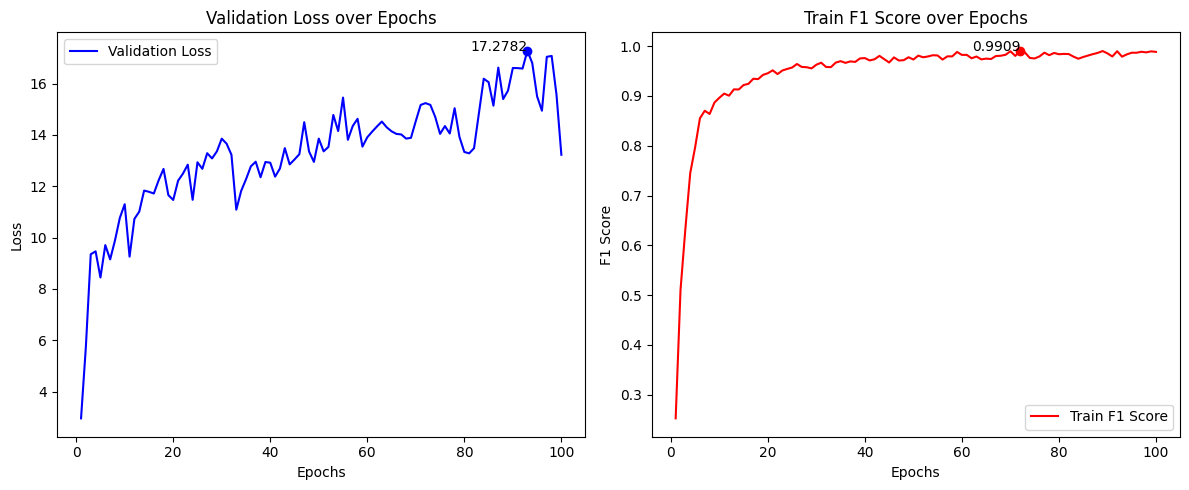

In [15]:
# 에폭 범위 설정
epochs = range(1, EPOCHS + 1)

# 검증 손실(val_loss) 변화 그래프
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, val_losses, 'b', label='Validation Loss')
plt.title('Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# val_loss 최대값과 해당 에폭
max_val_loss = max(val_losses)
max_val_loss_epoch = val_losses.index(max_val_loss) + 1
plt.scatter(max_val_loss_epoch, max_val_loss, color='blue')
plt.text(max_val_loss_epoch, max_val_loss, f'{max_val_loss:.4f}', ha='right')

# 학습 F1 스코어(train_f1) 변화 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_f1s, 'r', label='Train F1 Score')
plt.title('Train F1 Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

# train_f1 최대값과 해당 에폭
max_train_f1 = max(train_f1s)
max_train_f1_epoch = train_f1s.index(max_train_f1) + 1
plt.scatter(max_train_f1_epoch, max_train_f1, color='red')
plt.text(max_train_f1_epoch, max_train_f1, f'{max_train_f1:.4f}', ha='right')

plt.tight_layout()
plt.show()

## 6. 테스트 이미지 예측, 결과파일 저장

In [24]:
# 모델 초기화 및 로드
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)

model.load_state_dict(torch.load(best_model_path))
model.to(device)
model.eval()

preds_list = []

for image, _ in tqdm(tst_loader):
    image = image.to(device)

    with torch.no_grad():
        preds = model(image)
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)


INFO:timm.models._hub:[timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
100%|██████████| 25/25 [00:13<00:00,  1.83it/s]


In [25]:
pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list

In [26]:
sample_submission_df = pd.read_csv("/home/code/sample_submission.csv")
assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [27]:
pred_df.to_csv("240805-pred02.csv", index=False)

In [28]:
pred_df

ID  target
0     0008fdb22ddce0ce.jpg       2
1     00091bffdffd83de.jpg      12
2     00396fbc1f6cc21d.jpg       5
3     00471f8038d9c4b6.jpg      13
4     00901f504008d884.jpg       2
...                    ...     ...
3135  ffb4b6f619fb60ea.jpg       6
3136  ffb54299b1ad4159.jpg      10
3137  ffc2c91dff8cf2c0.jpg       8
3138  ffc4e330a5353a2a.jpg       0
3139  ffc71fed753d90c1.jpg      12

[3140 rows x 2 columns]

In [29]:
pred_df['target'].value_counts()

target
4     259
10    228
15    214
11    208
16    203
5     201
9     199
8     198
2     196
6     194
0     192
12    190
3     177
7     155
13    142
1     112
14     72
Name: count, dtype: int64

In [22]:
pred24080501 = pd.read_csv('/home/code/240805-pred01.csv')
pred24080501['target'].value_counts()

target
4     245
12    214
15    213
6     213
5     205
9     203
2     200
16    198
11    198
0     197
10    196
8     195
3     194
13    171
7     142
1      98
14     58
Name: count, dtype: int64